In [155]:
#%%

import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel, thirdordermodel

sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, discrete_ivp_solver, \
                    smooth_dap, sol_ivp_wrapper, sol_ivp_wrapper_discrete,\
                    smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont,\
                    build_initial_ipopt_object,\
                    consMatrix, f_with_consumption, plotSwitches, f_with_cost, \
                    consumption, stochasticSimulation_IDLE, removeRedundantSwitches



#%load_ext autoreload
#%autoreload 2

# PATHS
#FIGS = '/Users/madsobdrup/Dropbox/Skole/DTU/Studie/MASTER/THESIS/FIGS'

import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt


os.system("../model_loader.py")
os.system("../price_loader.py")
os.system("../../models/models.py")

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel, thirdordermodel


sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, discrete_ivp_solver, \
                    smooth_dap, sol_ivp_wrapper, sol_ivp_wrapper_discrete,\
                    smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont,\
                    build_initial_ipopt_object,\
                    consMatrix, f_with_consumption, plotSwitches, f_with_cost, \
                    consumption, stochasticSimulation_IDLE
from model_loader import *
from price_loader import *

# PATHS
#FIGS = '/Users/madsobdrup/Dropbox/Skole/DTU/Studie/MASTER/THESIS/FIGS'

# Switching time optimization modules
import switching_times_1st as st1
import switching_times_2nd as st2
import switching_times_3rd as st3

import switching_times_1st_rk as st1_rk
import lxml

In [156]:
model_sys = 1 #int(sys.argv[1])
n_days = 4 #int(sys.argv[2])
n_s = 4 #int(sys.argv[3])
true_sys = 3 #int(sys.argv[4])


k_baseline = 12400.
k_MELT = 250.
k_IDLE = 9.




logfile = open("../results/current_run_og.txt","w")
logfile.write("CURRENT RUN""\n")
logfile.write("--------------""\n")
logfile.write("Model: " + str(model_sys) +  "\n")
logfile.write("Number of days: " + str(n_days) +  "\n")
logfile.write("n_s: " + str(n_s) +  "\n")
logfile.write("True: " + str(true_sys) +  "\n")
logfile.write("--------------""\n")
logfile.close()


# BUILD OPTIMIZATION FUNCTION
# Define parameters
#n_s = 6
max_melt = 16. * 60.
dt_opt = 0.1

# ------ Define models -------
# Expectation and optimization object model
# -------------
if model_sys == 1:
    print(1)
    system_model = m1; x0_model = x0_1; tank = st1.plant(); tank_pars = m1.drift_pars; sys_mod = 'm1'
elif model_sys == 2:
    print(2)
    system_model = m2; x0_model = x0_2; tank = st2.plant(); tank_pars = m2.drift_pars; sys_mod = 'm2'
elif model_sys == 3:
    print(3)
    system_model = m3; x0_model = x0_3; tank = st3.plant(); tank_pars = m3.drift_pars; sys_mod = 'm3'
# -------------

# "True" model
# -------------
if true_sys == 1:
    print(1)
    system_true = m1; x0_true = x0_1; sys_true = 'm1'
elif true_sys == 2:
    print(2)
    system_true = m2; x0_true = x0_2; sys_true = 'm2'
elif true_sys == 3:
    print(3)
    system_true = m3; x0_true = x0_3; sys_true = 'm3'
# -------------


#%%

#%%
# Build object
t0 = 0.
tf_sim = 60 * 24
tf_ph = 60 * 48
opt_rk = False
tank = build_initial_ipopt_object(tank, tank_pars, dt_opt, k_baseline, k_MELT, k_IDLE, t0, tf_ph, max_melt, n_s, opt_rk)


# Build initial switches
# Build initial values - Other methods could be considered
idle = tf_ph * np.linspace(0.1,0.9,n_s) # Spread out on the whole interval
melt = idle - max_melt/n_s * 0.866 # Assign melt period to a little before idle
switch0_dap = np.concatenate((melt,idle)) # put together

switch0 = switch0_dap

tank.set_p_optimize(switch0)

# Build initial switches
# Build initial values - Other methods could be considered
idle = tf_ph * np.linspace(0.1,0.9,n_s) # Spread out on the whole interval
melt = idle - max_melt/n_s * 0.866 # Assign melt period to a little before idle
switch0_dap = np.concatenate((melt,idle)) # put together

switch0 = switch0_dap

tank.set_p_optimize(switch0)


#%%
# SIMUALTE
#n_days = 2
n_skip = 20 #int(1/ och_sim)
start_date = '2018-01-01 12:00:00'
dt_stoch_sim = 0.1
seed = 1235

# Derive convenient parameters
np.random.seed(1234)
n_per_day =  int(1/n_skip * 1/dt_stoch_sim *60 * 24)
t0_sim = t0
t0_ph = t0
total_sim_time = tf_sim - t0_sim

# Initialize processes
nx_true = x0_true.size
nx_model = x0_model.size

1
3


In [44]:

# Initialzie history
history = {}
history['X_true'] = np.zeros([n_days, nx_true, n_per_day])
history['X_true_idle'] = np.zeros([n_days, nx_true, n_per_day])
history['X_true_init_switch'] = np.zeros([n_days, nx_true, n_per_day])
history['X_model_dap'] = np.zeros([n_days, nx_model, n_per_day])

history['Z_true'] = np.zeros([n_days, 1, n_per_day])
history['Z_true_init_switch'] = np.zeros([n_days, 1, n_per_day])
history['Z_true_idle'] = np.zeros([n_days, 1, n_per_day])
history['Z_model_dap'] = np.zeros([n_days, 1, n_per_day])

history['T'] = np.zeros([n_days, n_per_day])

history['SWITCHES_dap'] = np.zeros([n_days, 2 * n_s])
history['SWITCHES_init_switch'] = np.zeros([n_days, 2 * n_s])
history['SWITCHES_rk'] = np.zeros([n_days, 2 * n_s])
history['PRICES_dap'] = np.zeros([n_days, 48])

history['price_model_dap'] = np.zeros([n_days,n_per_day])
history['price_true'] = np.zeros([n_days,n_per_day])
history['price_true_init_switch'] = np.zeros([n_days,n_per_day])
history['price_true_idle'] = np.zeros([n_days,n_per_day])

history['price_model_dap_each_hour'] = np.zeros([n_days,n_per_day])
history['price_true_each_hour'] = np.zeros([n_days,n_per_day])
history['price_true_each_hour_init_switch'] = np.zeros([n_days,n_per_day])
history['price_true_each_hour_idle'] = np.zeros([n_days,n_per_day])

history['cons_model_dap'] = np.zeros([n_days,n_per_day])
history['cons_true'] = np.zeros([n_days,n_per_day])
history['cons_true_init_switch'] = np.zeros([n_days,n_per_day])
history['cons_true_idle'] = np.zeros([n_days,n_per_day])

history['cons_model_dap_each_hour'] = np.zeros([n_days,n_per_day])
history['cons_true_each_hour'] = np.zeros([n_days,n_per_day])
history['cons_true_each_hour_init_switch'] = np.zeros([n_days,n_per_day])
history['cons_true_each_hour_idle'] = np.zeros([n_days,n_per_day])

history['opt_time'] = np.zeros([n_days,1])
history['sim_time'] = np.zeros([n_days,1])

history['start_date'] = start_date


price_true_lasthour = 0.
price_true_lasthour_init_switch = 0.
price_true_lasthour_idle = 0.
price_promised_lasthour = 0.

cons_true_lasthour = 0.
cons_true_lasthour_init_switch = 0.
cons_true_lasthour_idle = 0.
cons_promised_lasthour = 0.

start_true = np.array(x0_true)
start_true_init_switch = np.array(x0_true)
start_true_idle = np.array(x0_true)
start_promised = np.array(x0_model)

idx_offset = np.where(prices.index == start_date)[0][0]


for day in range(n_days):
    print('  ----- Simulating day ' + str(day) + ' ----  ')
    logfile = open("../results/current_run_og.txt","a")
    logfile.write("Simulating day " + str(day) + '\n')
    logfile.write("--------------\n")
    logfile.close()
    
    t0_sub = t0_sim/24.
    tf_sub = tf_sim/24.
    
    # Extract prices for optimization
    idx_offset = np.where(prices.index == start_date)[0][0]
    idx = np.arange(48) + day * 24 + idx_offset
    q_dap = np.array(prices['spot'][idx]).astype(np.float) # * 1/1000000
    
    # Insert new prices in optimization object
    p_dynamic = tank.get_p_dynamic()
    for k in range(0, 48):
        p_dynamic[k] = q_dap[k]
        #p_dynamic[48 + k] = q_rk[k]
        tank.set_p_dynamic(p_dynamic)
        
    # Initial state of the system
    start_promised = start_promised # Should be estimated with Kalman Filter
    tank.set_x0(np.append(start_promised,0)) 

    # Find optimal switches
    init_switch = tank.get_p_optimize()
    print(' ... Started optimizing')
    time_start = time.time()
    tank.solve()
    history['opt_time'][day] = time.time() - time_start
    print(' ... Finished optimizing')
    opt_switch = tank.get_p_optimize_ipopt()
    switch_promised = opt_switch[:2*n_s]
    #switch_used = opt_switch[2*n_s:]
    
    
    #switch_opt_dap = np.sort(np.random.uniform(0,tf_ph,2*n_s))
    #switch_promised = np.concatenate(derive_regimes(switch_opt_dap,0,0))
    #print(switch_opt_dap)

    #switch_opt_rk = np.sort(np.random.uniform(0,tf_ph,2*n_s))
    #switch_used = np.concatenate(derive_regimes(switch_opt_rk,0,0))
    #print(switch_opt_rk)
    
    
    # Simulate process and compute prices
    print(' ... Simulating processes')
    time_start = time.time()
    for hour in range(24):

        # ---------------------------
        # Simulate 1 day
        # ---------------------------
        # Remove switches closer to each other than 10 minutes
        switch_promised_filtered = removeRedundantSwitches(switch_promised,10)

        # Solve SDEs

        # True - Optimal switches
        if (switch_promised_filtered.size > 0):
            T_tmp, X_true, Y_true, Z_true = stochasticSimulation(system_true,switch_promised_filtered,start_true,t0_sub,tf_sub,dt_stoch_sim)
        else:
            T_tmp, X_true, Y_true, Z_true = stochasticSimulation_IDLE(system_true,start_true,t0_sub,tf_sub,dt_stoch_sim)

        # True - Always idle
        T_tmp_idle, X_true_idle, Y_true_idle, Z_true_idle = stochasticSimulation_IDLE(system_true,start_true_idle,t0_sub,tf_sub,dt_stoch_sim)

        # Expected  - Optimal switches
        T_tmp1, X_promised, Z_promised = sol_ivp_wrapper_discrete(system_model,start_promised,switch_promised_filtered,t0_sub,tf_sub,T_tmp)

        # True - Initial switches
        T_tmp_init_switch, X_true_init_switch, Y_true_init_switch, Z_true_init_switch = stochasticSimulation(system_true,init_switch,start_true_init_switch,t0_sub,tf_sub,dt_stoch_sim)


        # -----------------------------
        # Compute total consumption
        # -----------------------------
        # True
        cons_momental_true, cons_acc_true = consumption(Z_true[0],T_tmp,switch_promised,k_baseline,k_MELT,k_IDLE)

        # True - init switch
        cons_momental_true_init_switch, cons_acc_true_init_switch = consumption(Z_true_init_switch[0],T_tmp,init_switch,k_baseline,k_MELT,k_IDLE)
        
        # True IDLE - zero price of running the tank
        cons_momental_true_idle, cons_acc_true_idle = consumption(Z_true_idle[0],T_tmp,switch_promised,k_baseline,0,0)

        # Promised
        cons_momental_promised, cons_acc_promised = consumption(Z_promised[0],T_tmp,switch_promised,k_baseline,k_MELT,k_IDLE)

        # Compute payed prices
        price_payed = 1/1000000 *( cons_acc_true * q_dap[hour])
        price_payed_init_switch = 1/1000000 *( cons_acc_true_init_switch * q_dap[hour])
        price_payed_idle = 1/1000000 *( cons_acc_true_idle * q_dap[hour])
        price_promised = 1/1000000 *( cons_acc_promised * q_dap[hour])


        # -----------------------------
        # Save monitored variables
        # -----------------------------
        
        start = int(1/n_skip*1/dt_stoch_sim*hour*60)
        end = int(1/n_skip*1/dt_stoch_sim*(hour+1)*60)
        history['Z_true'][day][0][start:end] = Z_true[:,::n_skip]
        history['Z_true_init_switch'][day][0][start:end] = Z_true_init_switch[:,::n_skip]
        history['Z_true_idle'][day][0][start:end] = Z_true_idle[:,::n_skip]
        history['Z_model_dap'][day][0][start:end] = Z_promised[:,::n_skip]
        history['X_true'][day][:,start:end] = X_true[:,::n_skip]
        history['X_true_init_switch'][day][:,start:end] = X_true_init_switch[:,::n_skip]
        history['X_true_idle'][day][:,start:end] = X_true_idle[:,::n_skip]
        history['X_model_dap'][day][:,start:end] = X_promised[:,::n_skip]
        
        history['T'][day][start:end] = T_tmp[::n_skip] # Same in each day
        history['SWITCHES_dap'][day,:] = switch_promised
        history['SWITCHES_init_switch'][day,:] = init_switch
        history['PRICES_dap'][day,:] = q_dap

        # Price
        history['price_true'][day][start:end] = price_payed[::n_skip] + price_true_lasthour
        history['price_true_init_switch'][day][start:end] = price_payed_init_switch[::n_skip] + price_true_lasthour_init_switch
        history['price_true_idle'][day][start:end] = price_payed_idle[::n_skip] + price_true_lasthour_idle
        history['price_model_dap'][day][start:end] = price_promised[::n_skip] + price_promised_lasthour

        history['price_true_each_hour'][day][start:end] = price_payed[::n_skip]
        history['price_true_each_hour_init_switch'][day][start:end] = price_payed_init_switch[::n_skip]
        history['price_true_each_hour_idle'][day][start:end] = price_payed_idle[::n_skip]
        history['price_model_dap_each_hour'][day][start:end] = price_promised[::n_skip]

        # Consumption
        history['cons_true'][day][start:end] = cons_acc_true[::n_skip] + cons_true_lasthour
        history['cons_true_init_switch'][day][start:end] = cons_acc_true_init_switch[::n_skip] + cons_true_lasthour_init_switch
        history['cons_true_idle'][day][start:end] = cons_acc_true_idle[::n_skip] + cons_true_lasthour_idle
        history['cons_model_dap'][day][start:end] = cons_acc_promised[::n_skip] + cons_promised_lasthour

        history['cons_true_each_hour'][day][start:end] = cons_acc_true[::n_skip]
        history['cons_true_each_hour_init_switch'][day][start:end] = cons_acc_true_init_switch[::n_skip]
        history['cons_true_each_hour_idle'][day][start:end] = cons_acc_true_idle[::n_skip]
        history['cons_model_dap_each_hour'][day][start:end] = cons_acc_promised[::n_skip]
        

        # Update variables
        start_true = X_true[:,-1]
        start_true_init_switch = X_true_init_switch[:,-1]
        start_true_idle = X_true_idle[:,-1]
        start_promised = X_promised[:,-1] 
        t0_sub += total_sim_time/24.
        tf_sub += total_sim_time/24.

        price_true_lasthour = history['price_true'][day][end-1]
        price_true_lasthour_init_switch = history['price_true_init_switch'][day][end-1]
        price_true_lasthour_idle = history['price_true_idle'][day][end-1]
        price_promised_lasthour = history['price_model_dap'][day][end-1]

        cons_true_lasthour = history['cons_true'][day][end-1]
        cons_true_lasthour_init_switch = history['cons_true_init_switch'][day][end-1]
        cons_true_lasthour_idle = history['cons_true_idle'][day][end-1]
        cons_promised_lasthour = history['cons_model_dap'][day][end-1]
        

    history['sim_time'][day] = time.time() - time_start

    history['end_date'] = prices.index[idx[-1]]

    filenname = '../results/sim_history/og_history_(' + start_date + ')_(' + str(n_days) + '_days)' + '_(seed_' + str(seed) +  '_(n_s_' + str(n_s) + ')_(sys_model_' +  sys_mod + ')' + '_(sys_true_' + sys_true + ')' +  '.npy'
    np.save(filenname,history)



  ----- Simulating day 0 ----  
 ... Started optimizing
 ... Finished optimizing
 ... Simulating processes
  ----- Simulating day 1 ----  
 ... Started optimizing
 ... Finished optimizing
 ... Simulating processes
  ----- Simulating day 2 ----  
 ... Started optimizing
 ... Finished optimizing
 ... Simulating processes
  ----- Simulating day 3 ----  
 ... Started optimizing
 ... Finished optimizing
 ... Simulating processes


In [152]:
n_s = 6
model_sys = 'm1'
histories = {}
filename = '../results/sim_history/og_history_(2018-01-01 12:00:00)_(800_days)_(seed_1235_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m3).npy'
histories[str(n_s)] = np.load(filename,allow_pickle=True).item()

In [154]:
histories[str(n_s)]['opt_time']

array([[54.16606688],
       [38.66095877],
       [41.28108597],
       [34.64742398],
       [45.22543526],
       [37.90638423],
       [40.63463807],
       [42.84899712],
       [45.15661311],
       [30.89265013],
       [40.36515927],
       [39.9937861 ],
       [30.67744207],
       [38.43410277],
       [37.70477128],
       [44.43729997],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

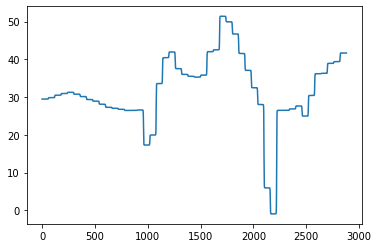

In [125]:
T = np.linspace(0,2*1440,2000)
plt.plot(T,smooth_dap(T,histories[str(n_s)]['PRICES_dap'][2]))

In [130]:
day = 2
histories[str(n_s)]['PRICES_dap'][day][:24], \
histories[str(n_s)]['PRICES_dap'][day][24:]

(array([29.49, 29.86, 30.51, 30.95, 31.28, 30.78, 30.15, 29.37, 28.93,
        28.13, 27.31, 27.05, 26.78, 26.47, 26.49, 26.6 , 17.31, 19.96,
        33.59, 40.45, 41.97, 37.55, 36.02, 35.53]),
 array([35.3 , 35.83, 42.04, 42.53, 51.43, 49.96, 46.73, 41.57, 37.09,
        32.49, 28.05,  5.96, -0.94, 26.5 , 26.5 , 26.88, 27.66, 24.98,
        30.44, 36.2 , 36.3 , 38.95, 39.4 , 41.69]))

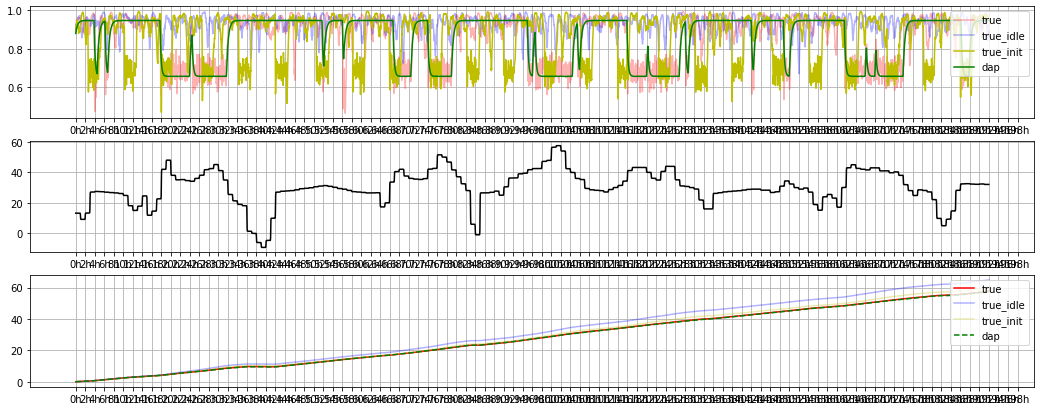

In [145]:
fig = plt.figure(figsize=(18,7))   
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
days_to_plot = range(0,8)
n_s = 6

Z_model_true_plot_idle =np.concatenate([histories[str(n_s)]['Z_true_idle'][day][0] for day in days_to_plot])
Z_model_true_plot =np.concatenate([histories[str(n_s)]['Z_true'][day][0] for day in days_to_plot])
Z_model_true_plot_init_switch =np.concatenate([histories[str(n_s)]['Z_true_init_switch'][day][0] for day in days_to_plot])
Z_model_dap_plot =np.concatenate([histories[str(n_s)]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[str(n_s)]['T'][0] + day * 60*24 for day in days_to_plot])

ax1.plot(T_plot,Z_model_true_plot,color = 'r',label= "true",alpha = 0.3)
ax1.plot(T_plot,Z_model_true_plot_idle,color = 'b',label= "true_idle",alpha = 0.3)
ax1.plot(T_plot,Z_model_true_plot_init_switch,color = 'y',label= "true_init",alpha = 1)
ax1.plot(T_plot ,Z_model_dap_plot,color = 'green', label='dap',alpha = 1)

ax1.legend(loc = 'upper right')
ax1.grid()

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax1.set_xticks(np.arange(0,total_number_of_days*25,2)*(60.) + days_to_plot[0] * 60 * 24)
ax1.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,total_number_of_days*25,2) * 60.])
    
all_dap = np.concatenate([histories[str(n_s)]['PRICES_dap'][day,:24] for day in days_to_plot])
all_time = np.concatenate([histories[str(n_s)]['T'][0] + day * 60*24 for day in days_to_plot])
ax2.plot(all_time,smooth_dap(all_time - all_time[0],all_dap),color='black',label='up')
ax2.set_xticks(np.arange(0,total_number_of_days*25,2)*(60.) + days_to_plot[0] * 60 * 24)
ax2.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,total_number_of_days*25,2) * 60.])
ax2.grid()

pricel_true_plot =np.concatenate([histories[str(n_s)]['price_true'][day] for day in days_to_plot])
pricel_true_plot_idle =np.concatenate([histories[str(n_s)]['price_true_idle'][day] for day in days_to_plot])
pricel_true_plot_init_switch =np.concatenate([histories[str(n_s)]['price_true_init_switch'][day] for day in days_to_plot])
pricel_dap_plot =np.concatenate([histories[str(n_s)]['price_model_dap'][day] for day in days_to_plot])



ax3.plot(T_plot,pricel_true_plot,color = 'r',label= "true",alpha = 1)
ax3.plot(T_plot,pricel_true_plot_idle,color = 'b',label= "true_idle",alpha = 0.3)
ax3.plot(T_plot,pricel_true_plot_init_switch,color = 'y',label= "true_init",alpha = 0.3)
ax3.plot(T_plot ,pricel_dap_plot,color = 'green', label='dap',alpha = 1,linestyle = '--')
ax3.set_xticks(np.arange(0,total_number_of_days*25,2)*(60.) + days_to_plot[0] * 60 * 24)
ax3.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,total_number_of_days*25,2) * 60.])
ax3.legend(loc = 'upper right')
ax3.grid()

#plotSwitches(histories[str(n_s)]['SWITCHES_dap'][0],0,'b','r',ax1)

#print(histories[str(4)]['SWITCHES_dap'])


In [146]:
histories[str(n_s)]['price_model_dap'][days_to_plot[-1]][-1],\
histories[str(n_s)]['price_true_init_switch'][days_to_plot[-1]][-1],\
histories[str(n_s)]['price_true'][days_to_plot[-1]][-1],\

(57.46276060412596, 59.71439937644994, 57.69390951864555)

# Optimized behaviour over 48 hours

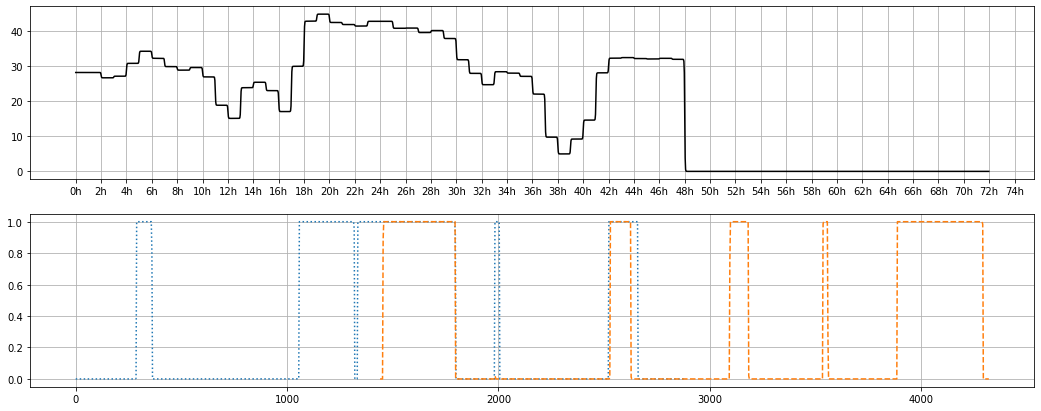

In [151]:
fig = plt.figure(figsize=(18,7))   
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

day = 6
days_to_plot = range(day,day+3)

all_dap = np.concatenate([histories[str(n_s)]['PRICES_dap'][day,:24] for day in days_to_plot])
all_time = np.concatenate([histories[str(n_s)]['T'][0] + day * 60*24 for day in days_to_plot])
ax1.plot(all_time,smooth_dap(all_time - all_time[0],all_dap),color='black',label='up')
ax1.set_xticks(np.arange(0,3*25,2)*(60.) + days_to_plot[0] * 60 * 24)
ax1.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,3*25,2) * 60.])
ax1.grid()


T1 = np.linspace(0,2*1440,1000)
T2 = np.linspace(1440,3*1440,1000)
ax2.plot(T1,smooth_regime(T1,histories[str(n_s)]['SWITCHES_dap'][days_to_plot[0]],10),linestyle = ':')
ax2.plot(T2,smooth_regime(T1,histories[str(n_s)]['SWITCHES_dap'][days_to_plot[1]],10),linestyle = '--')
ax2.grid()